# Replicate figure 4b from Nature Methods, Li etc. al. 

Here I attempt to replicate figure 4b from the below paper.  

https://www.nature.com/articles/s41592-022-01652-7?utm_source=twitter&utm_medium=social&utm_campaign=nmeth

I did not run their neural network (RLN), but simply ran a non-circulant classical Richardson Lucy with theoretical PSF assuming slight spherical aberration and compared it to the figure they provided


## Create a decon conda environment

In this environment we will install some tools we need for decon, this includes Jupyter noteook, opencl, fftw, clij2fft for non-circulant Richardson Lucy, devbio version of Napari for visualization, sdeconv for theoretical PSF, tnia-python XYZ projected figures in the notebook. 

    conda create --name decon-env python=3.9
    conda activate decon-env
    conda install -c conda-forge jupyterlab
    conda install -c conda-forge pyopencl==2021.2.6 hdbscan numba=0.55.1
    pip install devbio-napari
    conda install -c conda-forge fftw
    pip install napari-sdeconv
    pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python
    pip install --index-url https://test.pypi.org/simple/ --no-deps clij2-fft

Mac-users please also install this:

    conda install -c conda-forge ocl_icd_wrapper_apple

Linux users please also install this:

    conda install -c conda-forge ocl-icd-system


## Open test images

1.  Get images from here https://www.nature.com/articles/s41592-022-01652-7?utm_source=twitter&utm_medium=social&utm_campaign=nmeth#data-availability

2.  If trying to run this notebook on your own machine obviously change the paths to where you put the figures

In [3]:
import sys
sys.platform

'linux'

(61, 1024, 1024)


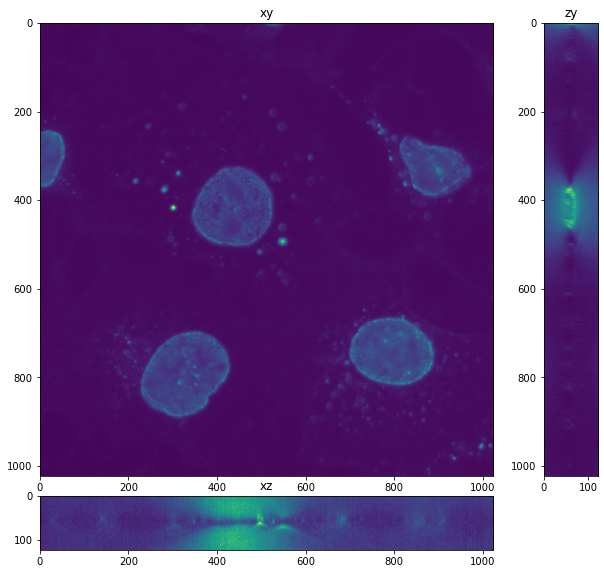

In [1]:
from skimage.io import imread
from tnia.plotting.projections import show_xyz_max, show_xyz_slice, show_xyz_slice_center, show_xyz_max
import numpy as np
import sys

if sys.platform=='linux':

else:
    im_path=r"D:\images\tnia-python-images\deconvolution\deep-learning\Figure4b\Figure4_training&test\test dataset\\"
    rln_path=r"D:\images\tnia-python-images\deconvolution\deep-learning\Figure4b\Figure4_training&test\RLN_output\\"

im_path=r"/home/bnorthan/Images/tnia-python-images/deconvolution/deep-learning/Figure4b/Figure4_training&test/test dataset/"
rln_path=r"/home/bnorthan/Images/tnia-python-images/deconvolution/deep-learning/Figure4b/Figure4_training&test/RLN_output/"

im_name='NPC-1.tif'
rln_name='RLN_NPC-1.tif'

im=imread(im_path+im_name)
rln=imread(rln_path+rln_name)
rln=np.squeeze(rln)

im=im.astype('float32')
print(im.shape)

fig=show_xyz_slice_center(im,1,2)

## Define an ROI to work with

We try to use the same ROI as in the paper (also define a second ROI which allows us to test quickly with a very small particle)

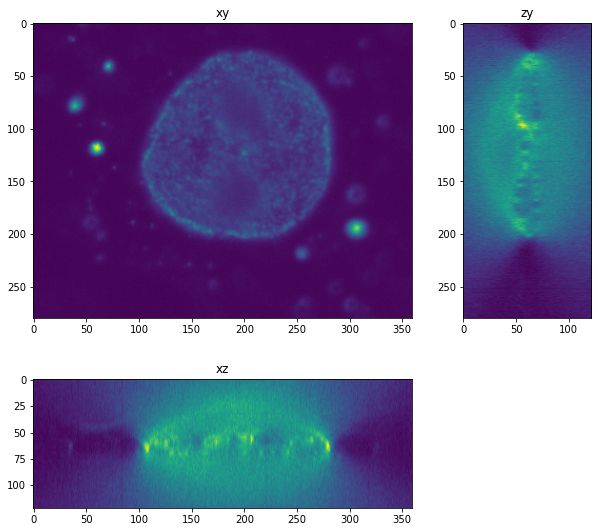

In [3]:
roi=np.s_[:, 300:580, 240:600]
#roi=np.s_[:, 390:450, 280:320]

im=im[roi]
im=np.flip(im,0)
rln=rln[roi]
rln=np.flip(rln,0)

fig=show_xyz_slice_center(im,1,2)


## Create PSF

From the paper xy voxel size is 0.101, NA 1.5, I assume a biological object with RI ~ 1.33, and calculate PSF at the center of the z range (so that the slight spherical aberration will be in the PSF). 

sdeconv 1.x.x detected


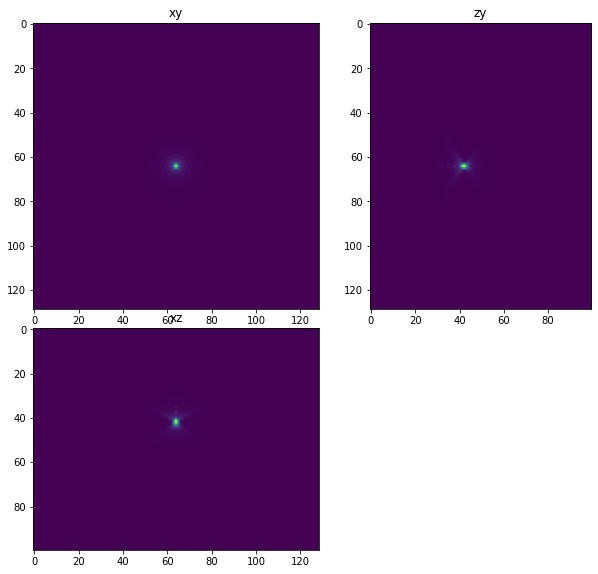

In [4]:
from tnia.deconvolution.psfs import gibson_lanni_3D

x_voxel_size = 0.101
z_voxel_size=.25

xy_psf_dim=129
z_psf_dim=100
z_d=61

NA=1.5
ni=1.5
ns=1.33

psf  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim, z_psf_dim, 1.5, 0.5)
psf = psf.astype('float32')
fig = show_xyz_max(psf)

# Recenter PSF

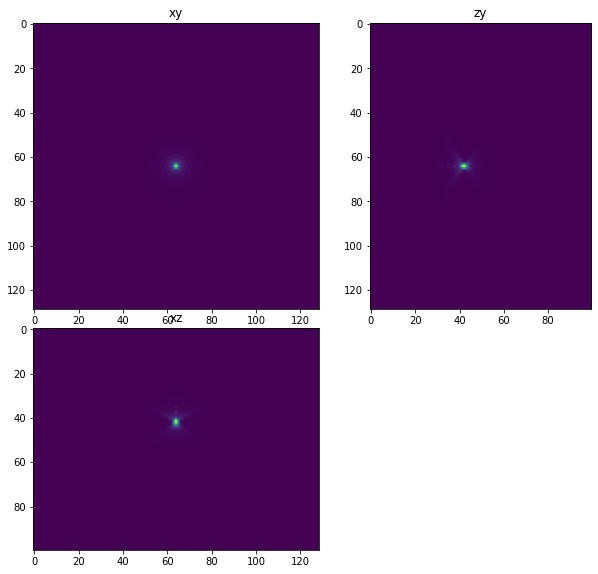

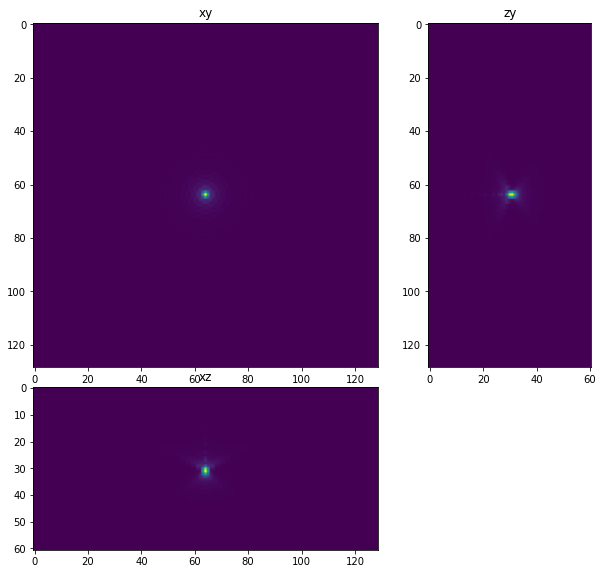

In [5]:
from tnia.deconvolution.psfs import recenter_psf_axial

fig=show_xyz_max(psf)
psf=recenter_psf_axial(psf, 61)
fig=show_xyz_max(psf)


## Deconvolve using non-circulant Richardson Lucy

In [8]:
from clij2fft.richardson_lucy import richardson_lucy_nc
regularization_factor=0.0
im_decon = richardson_lucy_nc(im, psf, 1000, regularization_factor)

get lib


Text(0.5, 1.0, 'Richardson Lucy Network')

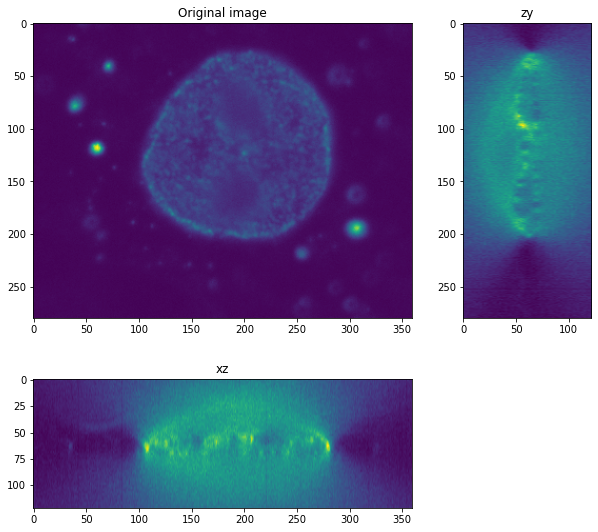

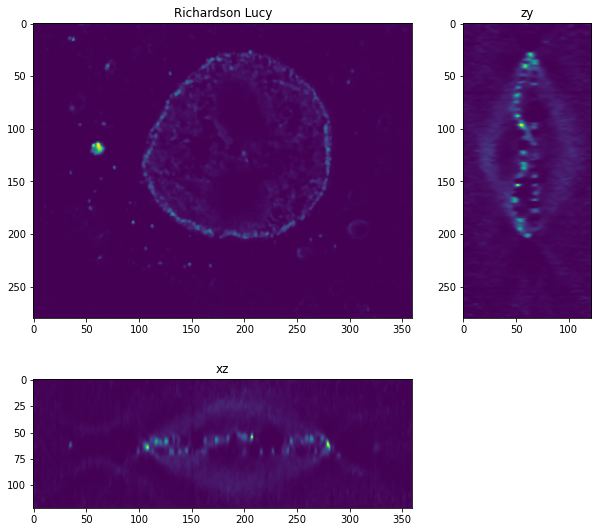

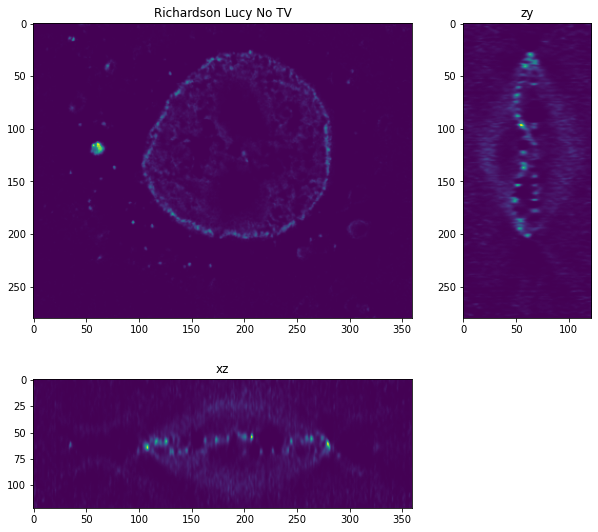

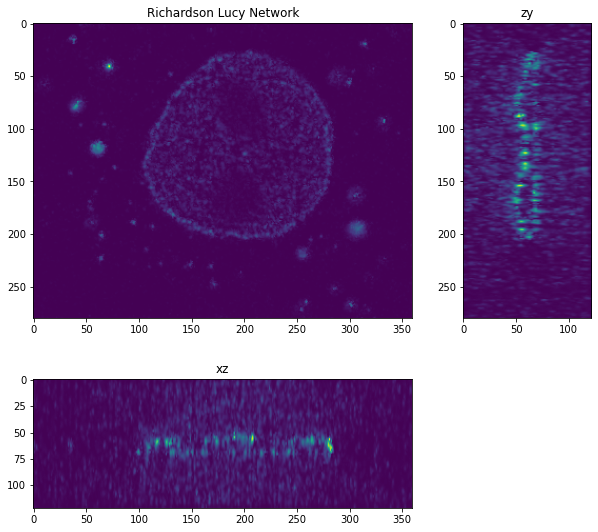

In [9]:
fig=show_xyz_slice_center(im,1,2)
fig.get_axes()[0].set_title('Original image')
#fig.suptitle('Original Image')
fig=show_xyz_slice_center(im_decon,1,2)
fig.get_axes()[0].set_title('Richardson Lucy')

fig=show_xyz_slice_center(im_decon_,1,2)
fig.get_axes()[0].set_title('Richardson Lucy No TV')


fig=show_xyz_slice_center(rln,1,2)
fig.get_axes()[0].set_title('Richardson Lucy Network')


## Visualize in Napari

In [10]:
import napari
viewer=napari.Viewer()

viewer.add_image(im, scale=(2,1,1))
viewer.add_image(im_decon, scale=(2,1,1))

viewer.add_image(im_decon_, scale=(2,1,1))

viewer.add_image(rln, scale=(2,1,1))


/home/bnorthan/anaconda3/envs/tnia_deconware/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in divide
  zoom = np.min(canvas_size / scale)


<Image layer 'rln' at 0x7fe073b4e670>

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'
